<a href="https://colab.research.google.com/github/tomasborrella/TheValley/blob/main/notebooks/spark02/Spark_DataFrames_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spark DataFrames 2

*   Transformaciones básicas
*   Ejemplo: imperativo vs veclarativo

Notebook por [Tomás Borrella Martín](https://www.linkedin.com/in/tomasborrella/).

### Enlaces de interés
*   [Slides de presentación](https://docs.google.com/presentation/d/1MotclVSrLoykWogG-WwLa-DbPNvVgHBaGuZJX2Gfc4o/edit?usp=sharing)

# 1. Instalación Spark

In [ ]:
# Install JAVA
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# Install Spark
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar xf spark-3.1.1-bin-hadoop2.7.tgz

In [ ]:
# Install findspark
!pip install -q findspark

In [ ]:
# Environment variables
import os 
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [ ]:
# Find spark
import findspark
findspark.init()

In [ ]:
# PySpark 
!pip install pyspark==3.1.1

# 2. Spark Session
Punto de entrada de la aplicación de Spark

In [ ]:
# Imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as f

In [ ]:
# Create Spark Session
spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("Spark Dataframes")
         .getOrCreate()
)

# Transformaciones básicas

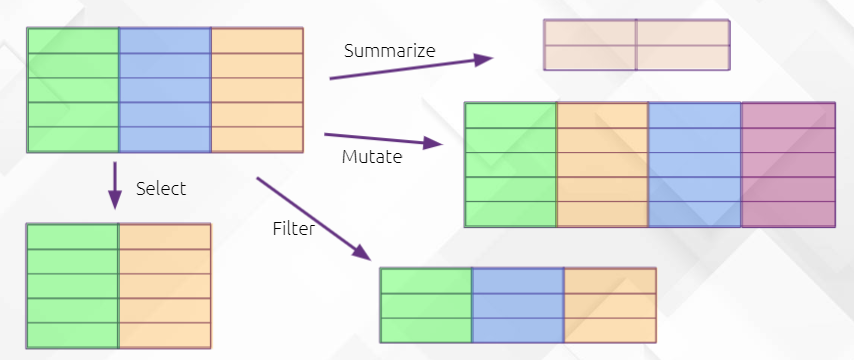

## Datos

In [ ]:
# Descargamos los datos desde Github al entorno de Colab
!wget -P /content/data 'https://raw.githubusercontent.com/tomasborrella/TheValley/main/data/spark02/puertos.csv'

Leemos el archivo con `SparkSession.read`

Al leer un archivo externo con Spark crea un DataFrame

[Documentación oficial de read](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.SparkSession.read.html#pyspark.sql.SparkSession.read)

In [ ]:
# Cargamos los datos en Spark
path = '/content/data/puertos.csv'
puertos = spark.read.csv(path, sep=';', header=True)

## Explorar datos

Mostramos información de su esquema con printSchema

[Documentación oficial de printSchema](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.printSchema.html#pyspark.sql.DataFrame.printSchema)

In [ ]:
puertos.printSchema()

In [ ]:
puertos.show(5)

## 1. Select

In [ ]:
puertos.select('Año', 'Mercancía General').show()

## 2. Summarize

In [ ]:
puertos.groupby('Año')

In [ ]:
puertos.groupby('Año').count().show()

## 3. Filter

In [ ]:
puertos.count()

In [ ]:
puertos.filter(f.col('Año') == '2009').count()

In [ ]:
puertos.filter(f.col('Año') == '2009').show()

Hay varias formas para indicar el nombre de una columna en Spark. Se suele hacer con la función `col`, aunque también puede hacerse como en Pandas indicando `dataframe.columna` o `dataframe['columna']`

In [ ]:
puertos.filter(puertos.Año == '2009').show(3)

In [ ]:
puertos.filter(puertos['Año'] == '2009').show(3)

## 4. Mutate

En Spark se crean columnas nuevas con `withColumn`

[Documentación oficial de withColumn](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.withColumn.html#pyspark.sql.DataFrame.withColumn)

In [ ]:
(
puertos
 .withColumn('Doble Buques', f.col('Buques') * 2)
 .select(f.col('Año'), f.col('Autoridad Portuaria'), f.col('Buques'), f.col('Doble Buques'))
 .show(3)
)

# Imperativo vs declarativo

## Ejemplo: Top 5 de años con más buques
Obtener la lista de los 5 años en los que hubo más Buques ordenada de mayor a menor y redondeado a 2 decimales.

### Imperativo

In [ ]:
(puertos.groupby('Año')
.agg(f.sum('Buques'))
.orderBy('sum(Buques)', ascending = False)
.select('Año', f.round('sum(Buques)', 2).alias("Tot. Buques"))
.limit(5)
.show())

### Declarativo

In [ ]:
# Se crea una vista temporal desde el DataFrame
puertos.createOrReplaceTempView("Tabla_puertos")

# Se ejecuta la consulta SQL sobre la vista temporal
spark.sql(
    """
    SELECT `Año`, ROUND (SUM (Buques), 2) as `Tot. Buques` 
    FROM Tabla_puertos 
    GROUP BY `Año` 
    ORDER BY `Tot. Buques` desc LIMIT 5
    """
    ).show()

# Ejercicio propuesto

Sobre unos dataset con tweets (tweets.json) obtener:

1.   Campos id, created_at y text de los diez primeros tweets del dataset.
2.   Campos id, name (del usuario) y location (del usuario).
3.   Los 10 usuarios con más amigos (campo friends_count).
4.   Los 10 usuarios con más tweets.

El dataset está subido a Google Drive: [Enlace](https://drive.google.com/file/d/18np5pJbHy1e1Dr1h17wTgZTb6-gJ23RJ/view?usp=sharing)

Para descargarlos se puede usar wget de esta forma:

```
# Descargamos los datos al entorno de Colab
!mkdir -p /content/data
!wget -O /content/data/tweets.json 'https://drive.google.com/uc?id=18np5pJbHy1e1Dr1h17wTgZTb6-gJ23RJ' 
```



# Spark Stop

In [ ]:
spark.stop()